<a href="https://colab.research.google.com/github/OuzounidisGeorgios/GeorgesO-Rep/blob/main/Fine_tuning_Hotel_Train%20and%20Test%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import pandas as pd
import xgboost as xgb
import numpy as np

In [89]:
# FINE TUNING 1) Re-import libraries in case this is a fresh Colab runtime

In [90]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [91]:
bookings = pd.read_csv('hotel_bookings_clean.csv')

In [92]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119210 non-null  int64  
 1   lead_time                       119210 non-null  int64  
 2   arrival_date_week_number        119210 non-null  int64  
 3   arrival_date_day_of_month       119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119206 non-null  float64
 9   babies                          119210 non-null  int64  
 10  is_repeated_guest               119210 non-null  int64  
 11  previous_cancellations          119210 non-null  int64  
 12  previous_booking

In [93]:
bookings.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119206.000000,119210.000000,...,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,104.109227,27.163376,15.798717,6.552051,0.927053,2.499195,1.859206,0.104047,0.007961,...,0.017549,0.005042,0.000050,0.876277,0.122364,0.001359,0.034158,0.004815,0.750575,0.210452
std,0.483012,106.875450,13.601107,8.781070,3.089796,0.995117,1.897106,0.575186,0.398842,0.097509,...,0.131305,0.070825,0.007094,0.329266,0.327707,0.036839,0.181636,0.069223,0.432682,0.407631
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,28.000000,16.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,161.000000,38.000000,23.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,53.000000,31.000000,12.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='is_canceled'>

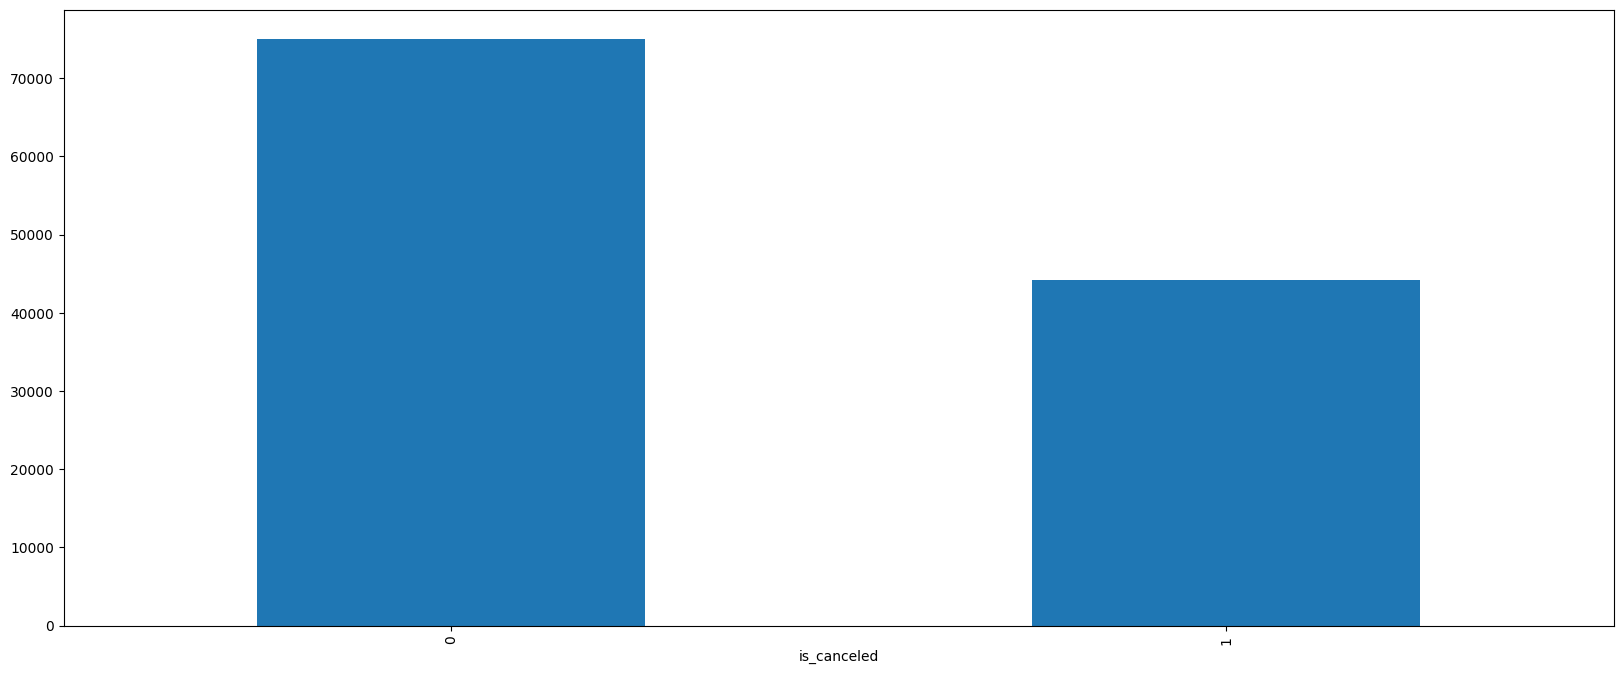

In [94]:
bookings['is_canceled'].value_counts().plot(kind='bar')

In [95]:
bookings['is_canceled'].value_counts()/bookings['is_canceled'].count()

,count
is_canceled,
0,0.629234
1,0.370766


In [96]:
# Time to split Our data
# Define X and y

In [97]:
X, y = bookings.iloc[:,1:], bookings.iloc[:,0]

In [98]:
# FINE TUNING 2) RE-SPLITING DATA
# stratify=y Ensures train and test sets have similar class distributions, Reduces the risk of skew imbalance
# Reproducibility: random_state=42

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [100]:
xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [101]:
xgb_clf.set_params(n_setimators=10)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              n_setimators=10, num_parallel_tree=None, ...)

In [102]:
xgb_clf.set_params(max_depth=3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              n_setimators=10, num_parallel_tree=None, ...)

In [103]:
xgb_clf.set_params(eval_metric='error')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              n_setimators=10, num_parallel_tree=None, ...)

In [104]:
# Fit into training set
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              n_setimators=10, num_parallel_tree=None, ...)

In [105]:
preds = xgb_clf.predict(X_test)
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'n_setimators': 10}

In [106]:
# Calculate the Accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
# Print the Accuracy
print("Baseline accuracy:", accuracy)

Baseline accuracy: 0.8256438218270279


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

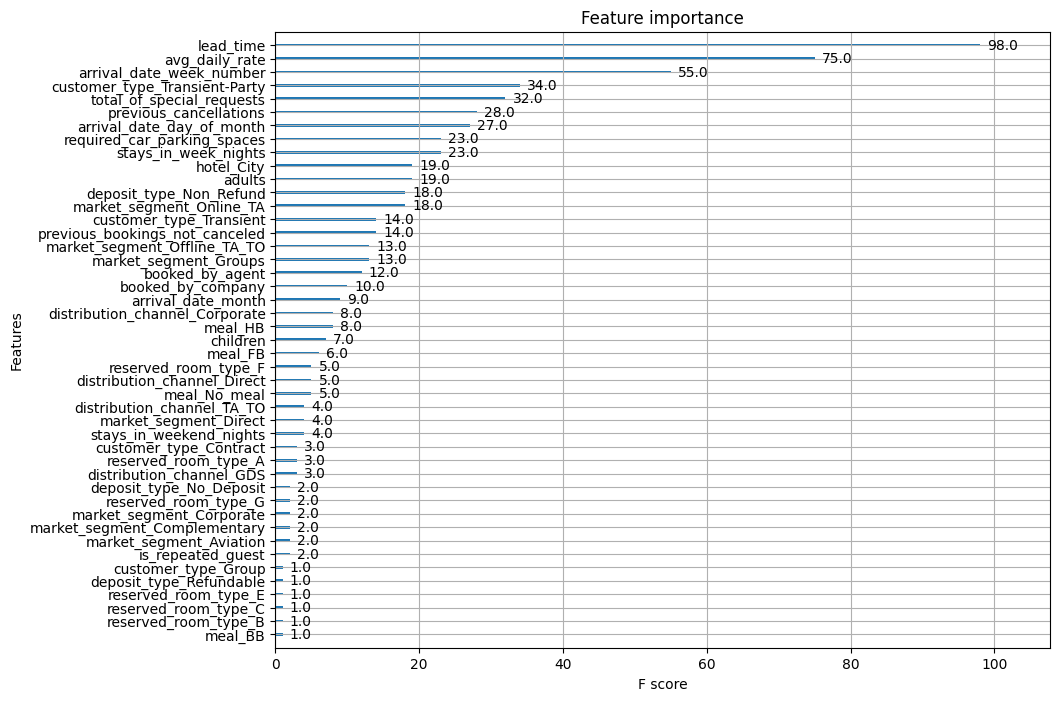

In [107]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8)
# Plot Feature importance
xgb.plot_importance(xgb_clf)

<Axes: >

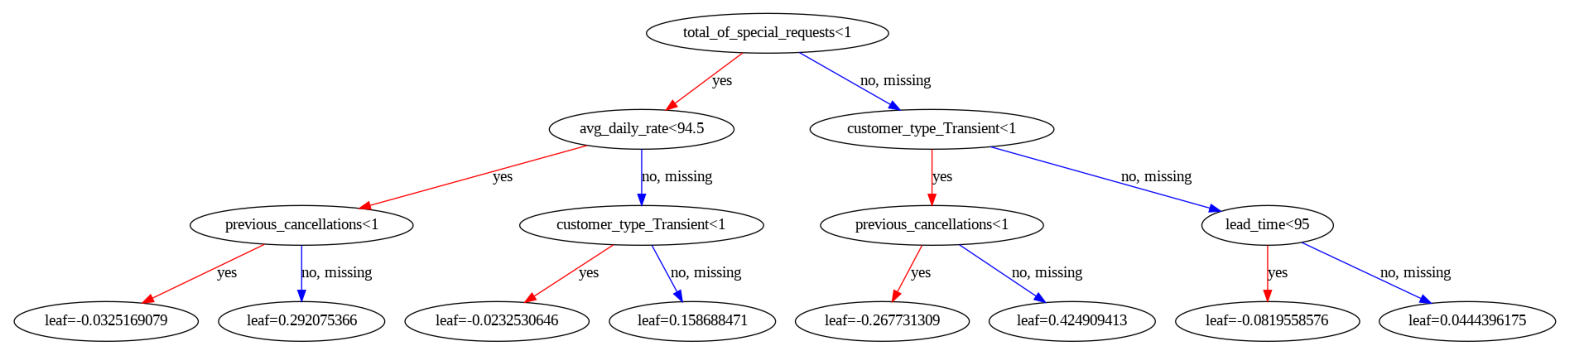

In [108]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Plot the first tree
xgb.plot_tree(xgb_clf, num_trees=9)

<Axes: >

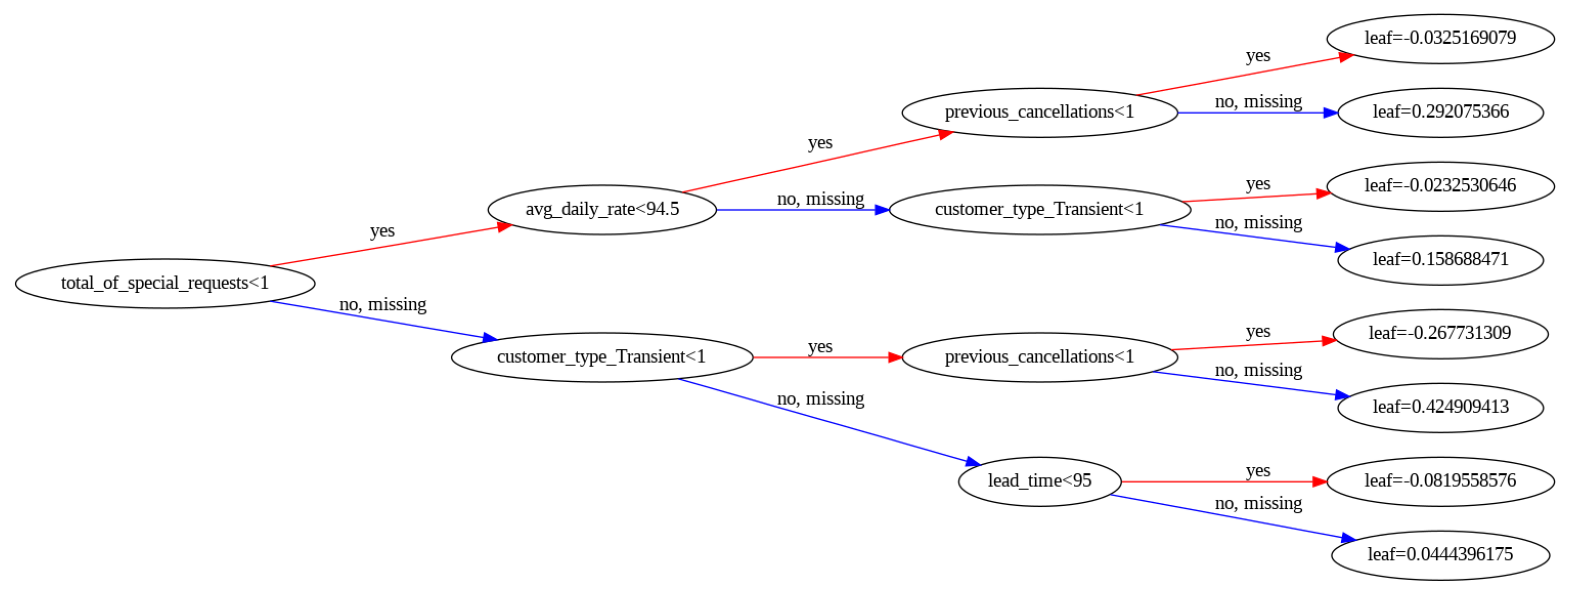

In [109]:
# Plot the tree left to right
xgb.plot_tree(xgb_clf, num_trees=9, rankdir='LR')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

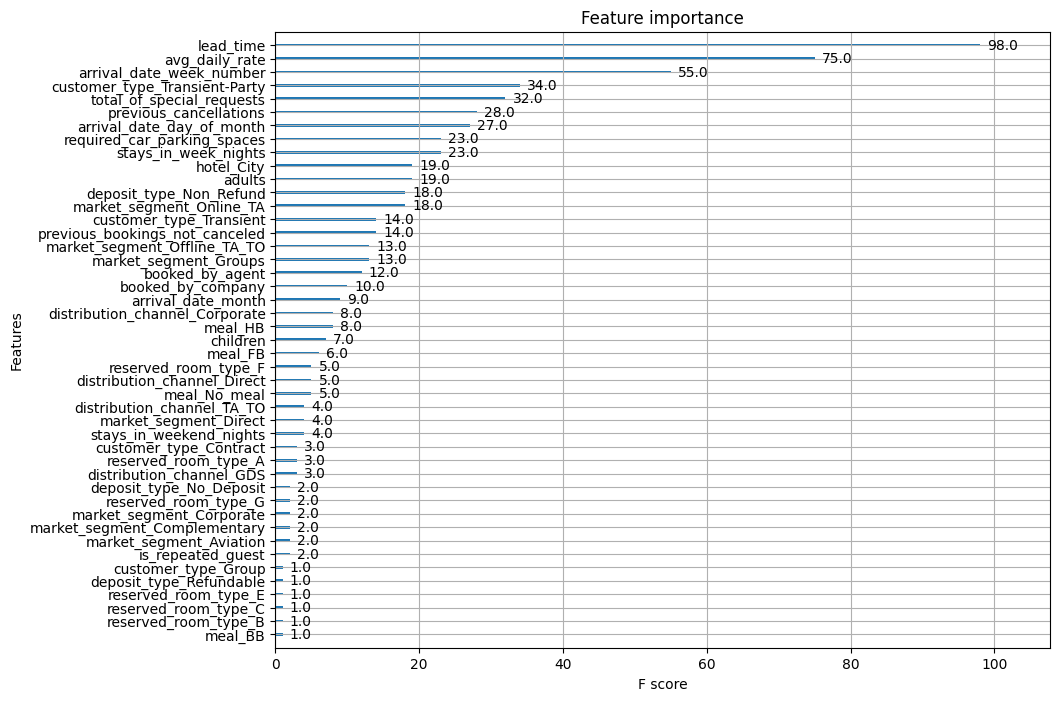

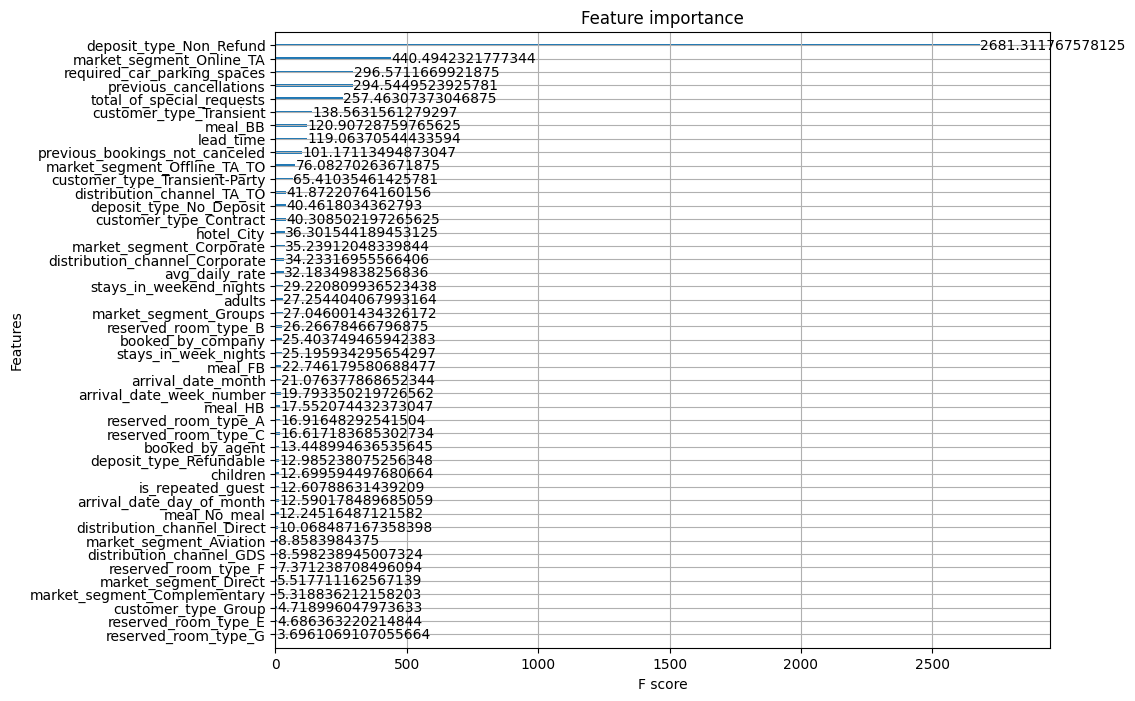

In [110]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8)
# Plot Feature importance
xgb.plot_importance(xgb_clf)

# Plot gain instead of weight
xgb.plot_importance(xgb_clf, importance_type='gain')

In [111]:
!pip install graphviz

<Axes: >

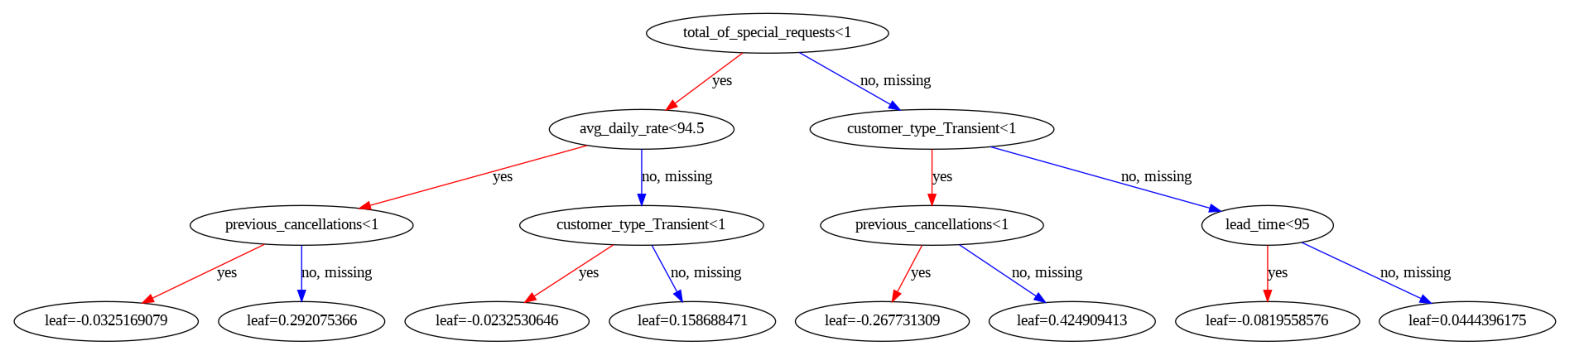

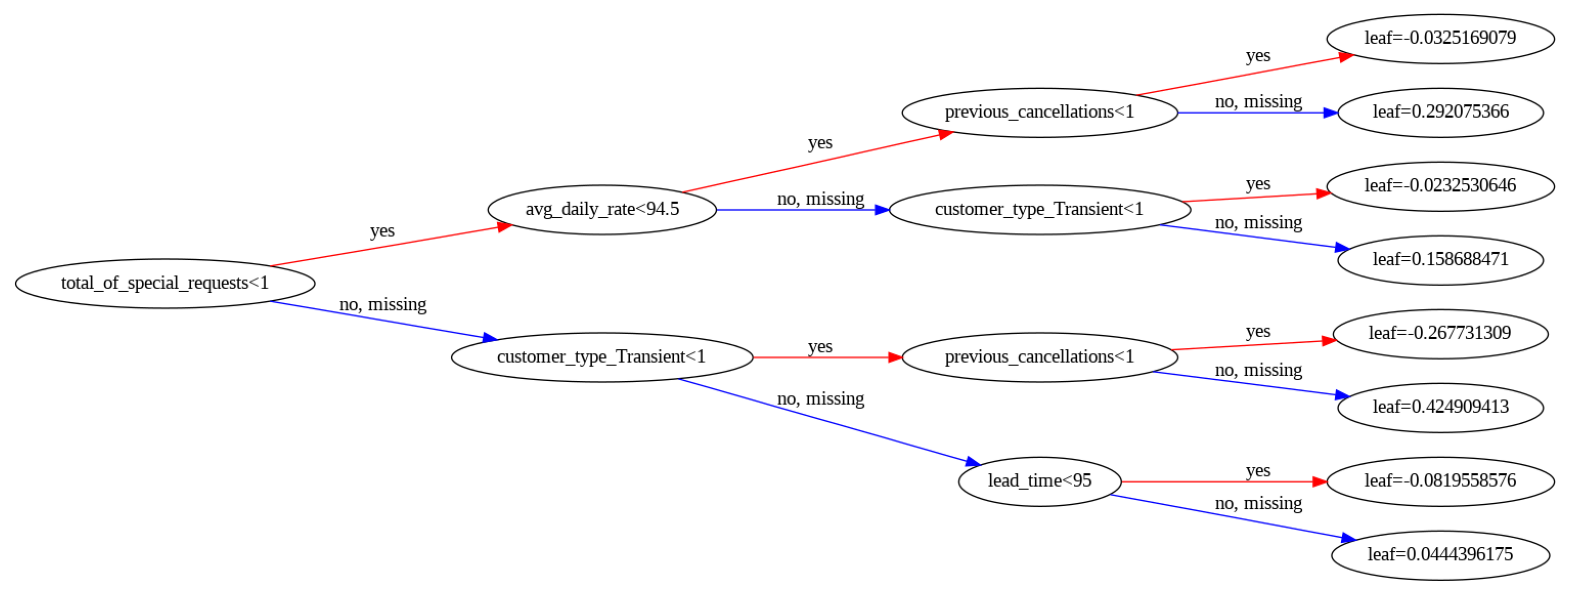

In [112]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Plot the first tree
xgb.plot_tree(xgb_clf, num_trees=9)

# Plot the tree left to right
xgb.plot_tree(xgb_clf, num_trees=9, rankdir='LR')

In [113]:
# FINE TUNING 4)
# Instantiate base XGBoost classifier

# n_estimators, max_depth: On the original Model are Manualy set (static)
# in the fine Tuned Model they are not set, they are tuned accordingly

# use_label_encoder	Not specified Explicitly disabled (prevents warnings)

# flexibility on the original Model is	Low – only uses fixed settings
# On the new Fine Tuned is Rather High – lets the model explore multiple configs from the dataset and the hotels.

# RandomizedSearchCV Not used in the original Notebook.
#	Now it is Wrapped in a tuning process for faster and randomized selection of bookings and/or data.

In [114]:
from sklearn.metrics import accuracy_score
#  Instantiate the XGBClassifires with 25 boosting rounds and error evaluation metric
xgb_clf = XGBClassifier(
    eval_metric='error',
    use_label_encoder=False,
    random_state=123
)



# MAX DEPTH
# Set Max depth to 10
xgb_clf.set_params(max_depth=10)

# fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8546682325308279

In [115]:
# FINE TUNING 5-6
# RandomizedSearchCV wrapper

# We use RandomizedSearchCV to explore 10 random combinations from the grid,
# using 3-fold cross-validation.
# This is faster than a full grid search while still improving performance.


# Fit model

In [116]:
xgb_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=10,                # Try 10 random combinations
    cv=3,                     # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,                # Use all CPU cores
    random_state=123
)

xgb_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           random_state=123, ...),
                   n_jobs=-1,
                   param_distributions={'alpha': [0, 0.01, 0.1],
                                        'colsample_bytree': [0.5, 0.7, 1],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12],
                                        'n_estimators': [50, 75, 100, 150],
                                        'subsample': [0.5, 0.75, 1]},
                   random_state=123, verbose=2)

In [117]:
# Set colsample_bytree to 0.5
xgb_clf.set_params(colsample_bytree=0.5)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8531582920895898

In [118]:
# Set subsample to 0.75
xgb_clf.set_params(subsample = 0.75)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8495931549366664

In [119]:
# GAMMA

# Set gamma to .25
xgb_clf.set_params(gamma=0.25)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)


0.8487962419260129

In [120]:
# LEARNING RATE
# Set the learning rate to .1
xgb_clf.set_params(learning_rate=0.1)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8487962419260129

In [121]:
# FINE TUNING 3) Define parameter grid for fine-tuning. This grid gives the model flexibility without being computationally overwhelming.
# max_depth: Controls tree depth

# n_estimators: Number of boosting rounds

# learning_rate: Step size shrinkage

# subsample: Fraction of rows used in each boosting round

# colsample_bytree: Fraction of columns used

# gamma: Minimum loss reduction before further splitting

# alpha: L1 regularization to reduce overfitting


In [122]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np  # Needed for np.linspace()

# DEFINE A PARAMETER GRID
param_grid = {
    'max_depth': list(range(3, 13)),
    'n_estimators': [50, 75, 100, 150],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.3],
    'alpha': [0, 0.01, 0.1]
}

In [123]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Instantiate XGBOOST Classifier
xgb_clf = XGBClassifier(eval_metric='error', random_state=123)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=rs_param_grid,
    cv=3,                 # 3-fold cross-validation
    n_iter=5,             # Try 5 random combinations
    verbose=2,
    n_jobs=-1             # Use all available CPU cores
)

# FINE TUNING 7): Evaluate best model
# We print:

# The best set of hyperparameters found
# The best average accuracy across all cross-validation folds
# This gives a sense of what combinations worked well for our specific dataset

y_pred_tuned = xgb_search.predict(X_test)

print("Best Parameters:", xgb_search.best_params_)
print("Best CV Accuracy:", xgb_search.best_score_)

print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

Best Parameters: {'subsample': 0.75, 'n_estimators': 150, 'max_depth': 11, 'learning_rate': np.float64(0.20333333333333334), 'gamma': 0.1, 'colsample_bytree': 1, 'alpha': 0.1}
Best CV Accuracy: 0.849698020784546

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89     15002
           1       0.84      0.76      0.79      8840

    accuracy                           0.86     23842
   macro avg       0.85      0.83      0.84     23842
weighted avg       0.85      0.86      0.85     23842


Confusion Matrix:
 [[13715  1287]
 [ 2161  6679]]


In [124]:
# FINE TUNING 8-9 EVALUATING on the Test Set
# 8)  We evaluate the model on the test set using:
# Accuracy
# Precision, recall, F1-score

# 9) Confusion Matrix
# This helps us understand how well the fine-tuned model generalizes to unseen data.

In [125]:
# 8
print("\n✅ Test Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred_tuned))


✅ Test Accuracy: 0.8553812599614127

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89     15002
           1       0.84      0.76      0.79      8840

    accuracy                           0.86     23842
   macro avg       0.85      0.83      0.84     23842
weighted avg       0.85      0.86      0.85     23842



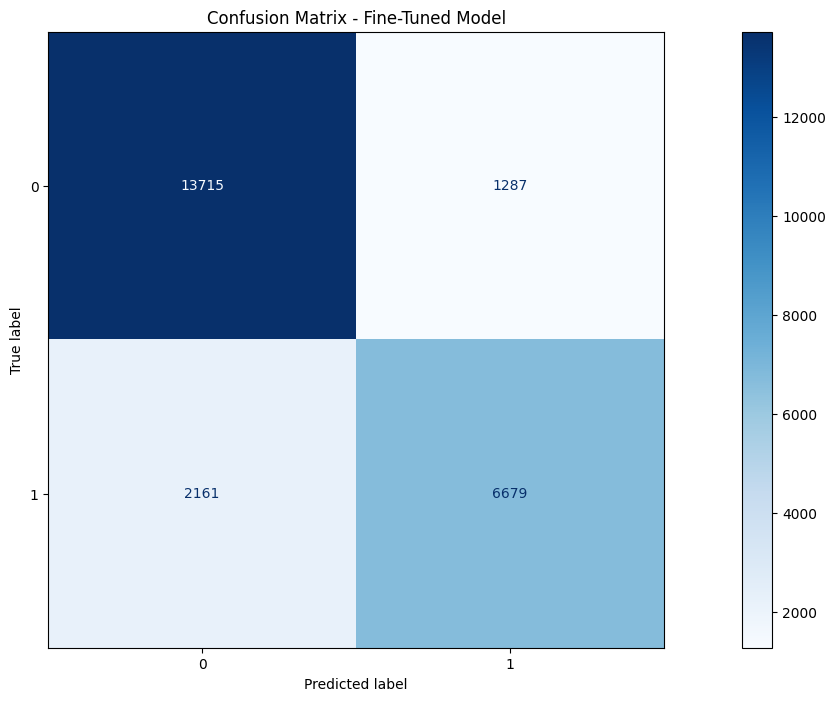

In [126]:
# 9
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_search.best_estimator_.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Fine-Tuned Model")
plt.grid(False)
plt.show()

In [127]:
# FINE TUNING 10
# We plot the top 10 features used by the fine-tuned model.
# This tells us which variables were most influential in predicting whether a booking was canceled.

<Figure size 1000x600 with 0 Axes>

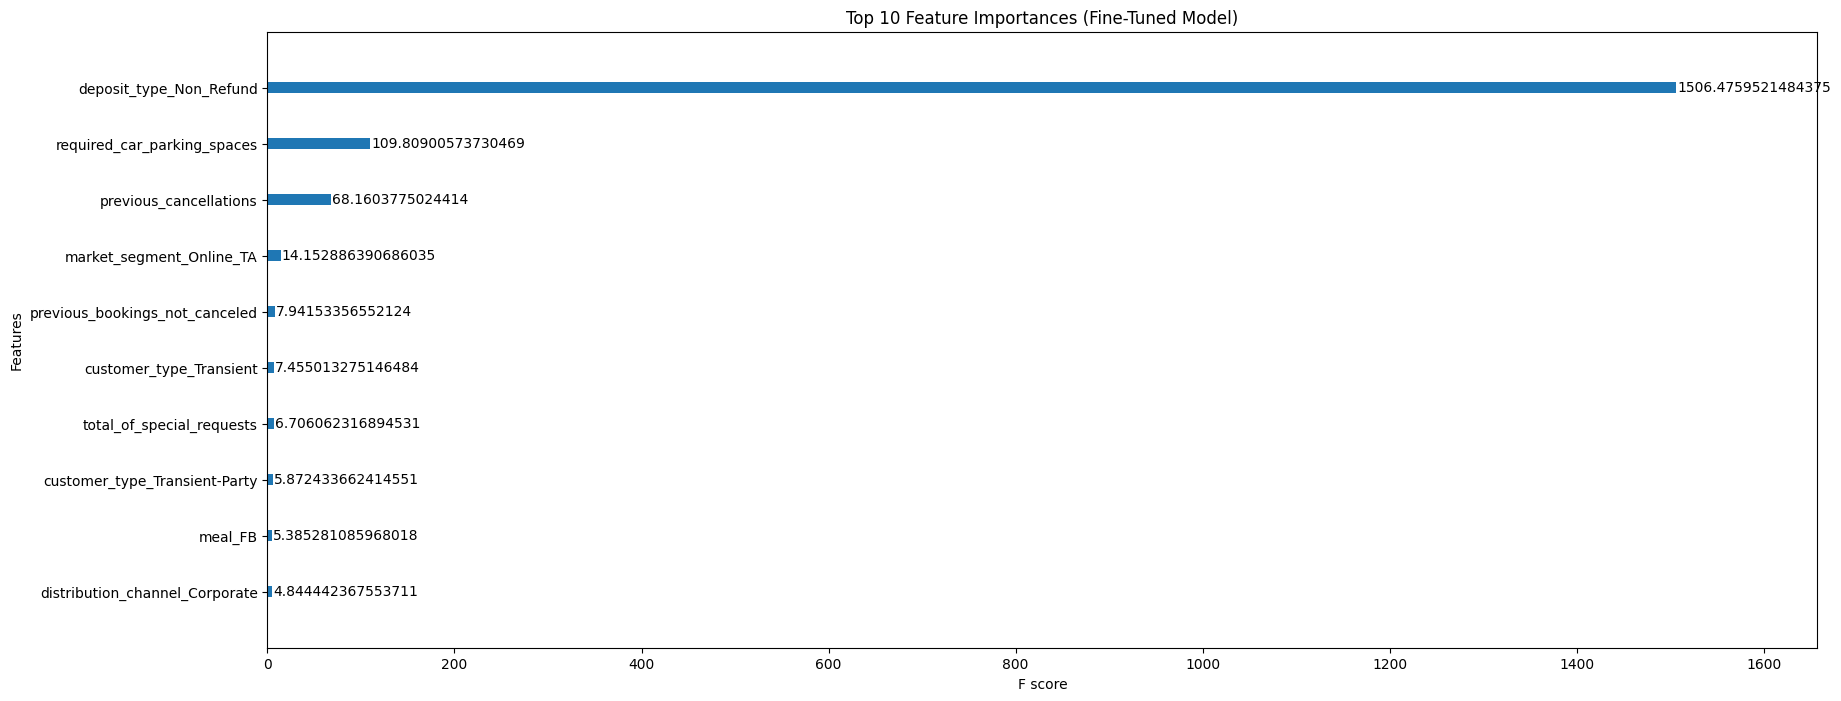

In [128]:
from xgboost import plot_importance

# Plot feature importances
plt.figure(figsize=(10, 6))
plot_importance(xgb_search.best_estimator_, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Fine-Tuned Model)")
plt.grid(False)
plt.show()